In [1]:
# !pip install datasets
# !pip install transformers[torch]
# !pip install accelerate -U

In [2]:
import torch
from src.utils import *
from src.models.models import BERT_Model_Phrase_Concatenation
from src.models.models import BERT_Model_Phrase_Extraction
from src.models.baseline import Baseline
from datasets import concatenate_datasets
from transformers import DefaultDataCollator, AutoTokenizer, TrainingArguments, Trainer

c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
RANDOM_SEED = 42
set_seeds(RANDOM_SEED)

print(torch.__version__)
print(torch.cuda.is_available())

2.2.2+cu121
True


In [4]:
url = "https://drive.google.com/uc?export=download&id=1wVNU2XvvhqjaGXZM-JLJwOt97gt4g9j2"
dataset_name = "MELD_train_efr.json"

df_manager = DataframeManager(url, dataset_name)

df = df_manager.produce_df()
df

Current work directory: c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref


,episode,emotions,utterances,triggers,emotions_id
0,utterance_0,"[neutral, neutral, neutral, neutral, surprise]",[also I was the point person on my company's t...,"[0, 0, 0, 1, 0]","[5, 5, 5, 5, 4]"
1,utterance_1,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 1, 0]","[5, 5, 5, 5, 4, 5, 5]"
2,utterance_2,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0]","[5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 6]"
3,utterance_3,"[neutral, neutral, neutral, neutral, surprise,...",[also I was the point person on my company's t...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 6, 5, 4]"
4,utterance_4,"[surprise, sadness, surprise, fear]",[But then who? The waitress I went out with la...,"[0, 0, 1, 0]","[4, 2, 4, 6]"
...,...,...,...,...,...
3995,utterance_3995,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[5, 1, 5, 5, 4, 3, 5, 3, 4, 5, 5, 3]"
3996,utterance_3996,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]","[5, 1, 5, 5, 4, 3, 5, 3, 4, 5, 5, 3, 3, 5]"
3997,utterance_3997,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[5, 1, 5, 5, 4, 3, 5, 3, 4, 5, 5, 3, 3, 5, 5]"
3998,utterance_3998,"[neutral, joy, neutral, neutral, surprise, dis...","[Hey., Hey!, So how was Joan?, I broke up with...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]","[5, 1, 5, 5, 4, 3, 5, 3, 4, 5, 5, 3, 3, 5, 5, 4]"


In [5]:
train_df, val_df, test_df = df_manager.split_df(RANDOM_SEED)
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(3200, 5)
(400, 5)
(400, 5)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\src\utils.py:269: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  return pd.DataFrame({key: pd.value_counts(values)
c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\src\utils.py:269: FutureWarning: value_counts with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  return pd.DataFrame({key: pd.value_counts(values)
c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\src\utils.py:269: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  return pd.DataFrame({key: pd.value_counts(values)
c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\edir

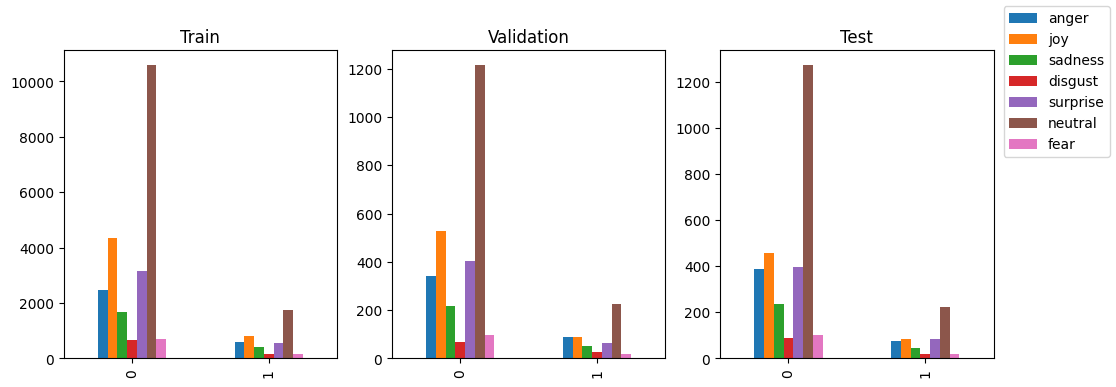

In [6]:
df_manager.plot_emotion_distribution(train_df, val_df, test_df)

In [7]:
model_card = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_card)

model_dir = "./model_dir/"+model_card+"/"
data_collator = DefaultDataCollator()

In [8]:
train_data_tokenized, val_data_tokenized, test_data_tokenized = df_manager.produce_dataset(tokenizer, RANDOM_SEED)

c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [9]:
print(len(train_data_tokenized))
print(len(val_data_tokenized))
print(len(test_data_tokenized))

2876
306
315


In [10]:
train_data_tokenized[0]

{'episode': 'utterance_555',
 'emotions_id_one_hot_encoding': tensor([0, 0, 1, 0, 0, 0, 0]),
 'emotions_id': tensor(2),
 'triggers': tensor(0),
 'dialogue_ids': tensor([  101,  2298,  1010,  1045,  2514,  2428,  2919,  2055,  2129,  1045,
         22783,  2017,  2041,  2077,  1010,  2061,  1045,  2170,  1996,  2269,
          1998,  2356,  2032,  2000,  3113,  2017,  2182,  2061,  2017,  2064,
          2425,  2032,  1012,   102,  2175,   999,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,

Models

In [11]:
seeds = [666, 55, 42]

X = train_data_tokenized['dialogue_index']
Y = train_data_tokenized.select_columns(['triggers', 'emotions_id'])
seed_table = {'majority': {}, 'uniform': {},
              'model_BERT': {}, 'model_BERT_Freezed': {}}

id2emotion = df_manager.get_id2emotion()
random_clf = Baseline("uniform", X, Y)
majority_clf = Baseline("most_frequent", X, Y)
for seed in seeds:
    seed_table["uniform"][seed] = random_clf.score()
    seed_table["majority"][seed] = majority_clf.score()

In [12]:
seed_table

{'majority': {666: {'accuracy_emotions': 0.1193,
   'accuracy_triggers': 0.0,
   'f1scores_emotions_instance': 0.0249,
   'f1scores_emotions_flatten': 0.0304,
   'f1scores_triggers_instance': 0.0,
   'f1scores_triggers_flatten': 0.0},
  55: {'accuracy_emotions': 0.1193,
   'accuracy_triggers': 0.0,
   'f1scores_emotions_instance': 0.0249,
   'f1scores_emotions_flatten': 0.0304,
   'f1scores_triggers_instance': 0.0,
   'f1scores_triggers_flatten': 0.0},
  42: {'accuracy_emotions': 0.1193,
   'accuracy_triggers': 0.0,
   'f1scores_emotions_instance': 0.0249,
   'f1scores_emotions_flatten': 0.0304,
   'f1scores_triggers_instance': 0.0,
   'f1scores_triggers_flatten': 0.0}},
 'uniform': {666: {'accuracy_emotions': 0.1436,
   'accuracy_triggers': 0.1446,
   'f1scores_emotions_instance': 0.0493,
   'f1scores_emotions_flatten': 0.0635,
   'f1scores_triggers_instance': 0.1575,
   'f1scores_triggers_flatten': 0.2017},
  55: {'accuracy_emotions': 0.1474,
   'accuracy_triggers': 0.1391,
   'f1sco

In [13]:
def init_pos_weight(data, labels, class_weights=True, factor=1):
    if class_weights:
        pos_weight = list()
        emotions_counts = {label:0 for label in df_manager.unique_emotions}
        for sentence_emotions in data[df_manager.column_emotions_id]:
            for emotion in sentence_emotions:
                emotions_counts[emotion] = emotions_counts[emotion] + 1
        sum_of_all_emotions = sum(emotions_counts.values())
        for label in labels:
            w = (sum_of_all_emotions-emotions_counts[label])/emotions_counts[label]   # num_neg/num_pos for each class as specified in the documentation for BCEWithLogitsLoss
            if w > 1:                       # increase recall of minority classes
                w*=factor                   # factor to magnify the weight (not standard)
                pos_weight.append(w)
            else:
                pos_weight.append(1)        # non minority classes are not influenced (pos_weight = 1)
        return torch.tensor(pos_weight).to("cuda")
    else:
        return torch.ones([len(labels)]).to("cuda")

In [14]:
model_B = BERT_Model_Phrase_Concatenation(df_manager)
def try_model_Concatenation(batch_start, batch_end):
        outputs_text = model_B(utterance_ids=train_data_tokenized[batch_start:batch_end]['utterance_ids'],
                utterance_mask=train_data_tokenized[batch_start:batch_end]['utterance_mask'],
                dialogue_ids=train_data_tokenized[batch_start:batch_end]['dialogue_ids'],
                dialogue_mask=train_data_tokenized[batch_start:batch_end]['dialogue_mask'],
                token_type_ids=None)
        return outputs_text
#outputs_text = try_model_Concatenation(0, 30)
#print(outputs_text['emotion_logits'].shape)
#print(outputs_text['trigger_logits'].shape)

In [32]:
class MultiLabelTrainer(Trainer):
    def __init__(self, pos_weight, **kwargs):
        self.pos_weight = pos_weight
        super().__init__(**kwargs)

    def compute_loss(self, model, inputs, return_outputs=False):
        emotions_true = inputs["emotions_id_one_hot_encoding"].to("cuda")
        triggers_true = inputs["triggers"].float().unsqueeze(1).to("cuda")

        result = model(**inputs)
        
        emotion_logits = result['emotion_logits'].to("cuda")
        trigger_logits = result['trigger_logits'].to("cuda")
        
        loss_fct_emotions = torch.nn.BCEWithLogitsLoss(pos_weight=self.pos_weight)        
        loss_fct_triggers = torch.nn.BCEWithLogitsLoss()

        loss_triggers = loss_fct_triggers(trigger_logits, triggers_true)
        loss_emotions = loss_fct_emotions(emotion_logits, emotions_true.float())

        loss = loss_emotions + loss_triggers
        return (loss, {'emotion_logits': emotion_logits, 'trigger_logits': trigger_logits}) if return_outputs else loss

def get_trainer(model, train, val, model_dir, class_weights=True, batch_size=1, epochs=20):
    training_args = TrainingArguments(
        output_dir=model_dir,
        learning_rate=2e-2,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        num_train_epochs=epochs,
        weight_decay=0.01,
        evaluation_strategy="epoch",
        save_strategy="epoch",
        lr_scheduler_type="cosine_with_restarts",
        save_total_limit = 1,
        load_best_model_at_end=True,
        metric_for_best_model='f1scores_emotions_instance',
        report_to='none',
        label_names=["emotions_id", "triggers", "dialogue_index", "emotions_id_one_hot_encoding"],
    )
    pos_weight = init_pos_weight(concatenate_datasets([train_data_tokenized, val_data_tokenized, test_data_tokenized]), df_manager.emotion2id.keys(), False)
    trainer = MultiLabelTrainer(
        pos_weight=pos_weight,
        model=model,
        args=training_args,
        train_dataset=train,
        eval_dataset=val,
        tokenizer=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics_for_trainer,
    )

    return trainer

In [33]:
#intialize class for error analysis (SELECT FIRST WHICH DATASET TO USE)

from src import error
report = error.ErrorAnalysis(test_data_tokenized)
train_report = error.ErrorAnalysis(train_data_tokenized)

In [34]:
seeds = [666]
for seed in seeds:
        set_seeds(seed)
        base_model = BERT_Model_Phrase_Concatenation(df_manager)
        # base_model_freezed = BERT_Model(freeze=True)

        # Create trainer for Conclusion only
        trainer = get_trainer(base_model, train_data_tokenized, val_data_tokenized, model_dir+"baseline", class_weights=True, batch_size=1, epochs=1)

        # Create trainer for Conclusion+Premises
        # trainer_freezed = get_trainer(base_model_freezed, train_dataset, val_dataset, model_dir+"baseline_freezed", class_weights=True, batch_size=1, epochs=10)
        print(f'Training BASE_MODEL with seed {seed}:')
        #trainer.evaluate(val_data_tokenized[0])

        trainer.train()

        #print(f'Training BASE_MODEL_FREEZED with seed {seed}:')
        #trainer_freezed.train()

        #add predictions to the error analysis report for later analysis
        train_report.add_model(trainer, train_data_tokenized, 'baseline', seed)
        report.add_model(trainer, test_data_tokenized, 'baseline', seed)

        #test_prediction_info = trainer.predict(dataset)
        #test_predictions, test_labels = test_prediction_info.predictions, test_prediction_info.label_ids
        #test_metrics.append(compute_metrics([test_predictions, test_labels], list(level_2.keys())))
#
        ## fill seed table
        #seed_table["model_BERT"][seed] = test_bert
        #seed_table["model_BERT_Freezed"][seed] = test_CP

c:\Users\cacio\Desktop\jacopo\scuola\UNIBO MASTER\NATURAL LANGUAGE PROCESSING\project\ediref\ediref\Lib\site-packages\accelerate\accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Training BASE_MODEL with seed 666:


 17%|█▋        | 501/2876 [01:02<04:50,  8.18it/s]

{'loss': 1.4135, 'grad_norm': 1.3576300261775032e-06, 'learning_rate': 0.018545180963372272, 'epoch': 0.17}


 35%|███▍      | 1001/2876 [02:04<03:48,  8.22it/s]

{'loss': 1.4112, 'grad_norm': 6.503175313810061e-07, 'learning_rate': 0.014604023539355979, 'epoch': 0.35}


 52%|█████▏    | 1502/2876 [03:07<02:41,  8.52it/s]

{'loss': 1.4095, 'grad_norm': 3.7099843552823586e-07, 'learning_rate': 0.009323261897312238, 'epoch': 0.52}


 70%|██████▉   | 2001/2876 [04:08<01:49,  7.98it/s]

{'loss': 1.4106, 'grad_norm': 2.941509649190266e-07, 'learning_rate': 0.0042394065501887915, 'epoch': 0.7}


 87%|████████▋ | 2502/2876 [05:09<00:44,  8.36it/s]

{'loss': 1.408, 'grad_norm': 3.432647019963042e-07, 'learning_rate': 0.0008316754056770137, 'epoch': 0.87}


100%|██████████| 2876/2876 [06:04<00:00,  7.92it/s]

{'eval_loss': 1.4146580696105957, 'eval_accuracy_emotions': 0.4216, 'eval_accuracy_triggers': 0.7876, 'eval_f1scores_emotions_instance': 0.0825, 'eval_f1scores_emotions_flatten': 0.0847, 'eval_f1scores_triggers_instance': 0.4183, 'eval_f1scores_triggers_flatten': 0.4406, 'eval_runtime': 8.717, 'eval_samples_per_second': 35.104, 'eval_steps_per_second': 35.104, 'epoch': 1.0}


100%|██████████| 2876/2876 [06:06<00:00,  7.84it/s]


{'train_runtime': 366.9732, 'train_samples_per_second': 7.837, 'train_steps_per_second': 7.837, 'train_loss': 1.4105104703730769, 'epoch': 1.0}


100%|██████████| 2876/2876 [01:22<00:00, 34.74it/s]


torch.Size([2876, 7]) torch.Size([2876, 1])


100%|██████████| 315/315 [00:09<00:00, 33.86it/s]

torch.Size([315, 7]) torch.Size([315, 1])


### ERROR ANALYSIS
Check if you have added models to the Error analysis class. After which you can call all the functions you want. Predictions should be stored inside a dataframe, emotions and triggers in two separated columns. The columns should have respectively "<MODEL_NAME>_<SEED>" and "<MODEL_NAME>_<SEED>_T" names. If they don't have been added but you still have the model, you can add predictions directly with .add_predictions()... Do it twice, onece adding emtions predictions and once adding trigger predictions. When adding, the model name should be just the name.

In [20]:
# from src import error
# import importlib
# importlib.reload(error)

In [21]:
#report = error.ErrorAnalysis(test_data_tokenized)

In [22]:
# report.add_model(trainer, test_data_tokenized, 'baseline', seeds[0])

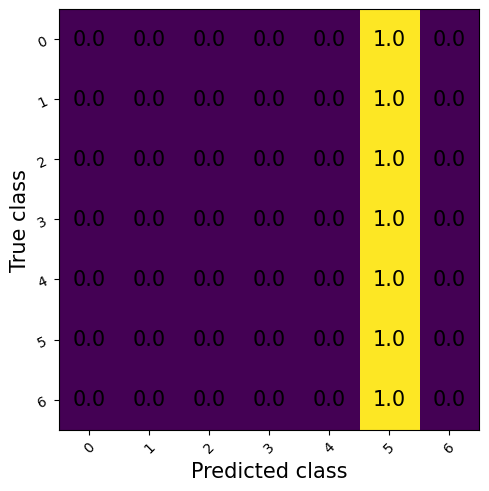

In [35]:
_ = report.get_confusion_matrix('baseline_666', plot = True)

In [36]:
table = report.get_performance_table(metrics = ['accuracy','f1_macro','f1_micro','f1_weighted'])
report_df = pd.DataFrame(table.values())
report_df = report_df.map(lambda x: x.item() if type(x) == torch.Tensor else x)
report_df

,name,accuracy,f1_micro,f1_macro,f1_weighted,accuracy_t,f1_t
0,baseline_666,0.142857,0.473016,0.091749,0.30379,0.809524,0.0


In [37]:
report.df['baseline_666'].unique()

array([tensor([0.0000e+00, 0.0000e+00, 2.8603e-20, 3.8101e-23, 5.6365e-19, 1.0000e+00,
               1.3412e-24])                                                           ,
       tensor([0.0000e+00, 0.0000e+00, 2.8603e-20, 3.8101e-23, 5.6366e-19, 1.0000e+00,
               1.3412e-24])                                                           ,
       tensor([0.0000e+00, 0.0000e+00, 2.8603e-20, 3.8101e-23, 5.6366e-19, 1.0000e+00,
               1.3412e-24])                                                           ,
       tensor([0.0000e+00, 0.0000e+00, 2.8603e-20, 3.8101e-23, 5.6365e-19, 1.0000e+00,
               1.3412e-24])                                                           ,
       tensor([0.0000e+00, 0.0000e+00, 2.8603e-20, 3.8101e-23, 5.6366e-19, 1.0000e+00,
               1.3412e-24])                                                           ,
       tensor([0.0000e+00, 0.0000e+00, 2.8603e-20, 3.8101e-23, 5.6365e-19, 1.0000e+00,
               1.3412e-24])           

In [19]:
# ALL IS WORKING FINE
report.get_trigger_effect('baseline_666')
report.get_confusion_matrix('baseline_666', plot = False)
report.get_confusion_matrix('baseline_666_t', plot = False)
report.get_precision_recall('baseline_666', plot = False)
report.get_precision_recall('baseline_666_t', plot = False)
report.get_emotions_table()
report.get_misclassified('baseline_666')
report.get_misclassified('baseline_666_t')
report.get_performance_table()
report.get_trigger_table()
report.get_utterance_ranking('baseline_666')
report.get_utterance_ranking('baseline_666_t')


,accuracy,dialogue_len
episode,,
utterance_2863,0.200000,10.0
utterance_2848,0.333333,15.0
utterance_3191,0.333333,3.0
utterance_1443,0.400000,5.0
utterance_1682,0.600000,5.0
utterance_3791,0.600000,5.0
utterance_2199,0.666667,6.0
utterance_1696,0.666667,3.0
utterance_1919,0.666667,3.0


In [ ]:
#Some functions return dict or list of dict. check usage in error_analysis.ipynb If you want dataframes visualization, you can do something like this
table = report.get_emotions_table()
print(table)
table_df = pd.DataFrame(table.values())
table_df = table_df.map(lambda x: x.item() if type(x) == torch.Tensor else x)
table_df